In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib.pyplot as plt

# Vocabulary, SequenceVocabulary

In [3]:
class Vocabulary():
  def __init__(self, token_to_idx=None):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx:token for token, idx in self._token_to_idx.items()}

  def to_serializable(self):
    return {"token_to_idx": self._token_to_idx}

  @classmethod
  def from_serializable(cls, contents):
    return cls(**contents)

  def add_token(self, token):
    if token in self._token_to_idx:
      index = self._token_to_idx[token]
    else:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index

  def add_many(self, tokens):
    return [self.add_token(token) for token in tokens]

  def lookup_token(self,token):
    return self._token_to_idx[token]

  def lookup_index(self, index):
    if index not in self._idx_to_token:
      raise KeyError("the index (%d) is not in the Vocabulary" % index)
    return self._idx_to_token[index]

  def __str__(self):
    return "<Vocabulary(size=%d)>" % len(self)

  def __len__(self):
    return len(self._token_to_idx)

In [4]:
class SequenceVocabulary(Vocabulary): #상속
  def __init__(self, token_to_idx= None, unk_token="<UNK>",
               mask_token="<MASK>", begin_seq_token="<BEGIN>",
               end_seq_token="<END>"):
    super(SequenceVocabulary, self).__init__(token_to_idx)

    self._mask_token = mask_token
    self._unk_token = unk_token
    self._begin_seq_token = begin_seq_token
    self._end_seq_token = end_seq_token

    self.mask_index = self.add_token(self._mask_token)
    self.unk_index = self.add_token(self._unk_token)
    self.begin_seq_index = self.add_token(self._begin_seq_token)
    self.end_seq_index = self.add_token(self._end_seq_token)

  def to_serializable(self):
    contents = super(SequenceVocabulary, self).to_serializable()
    contents.update(
        {
            "unk_token": self._unk_token,
            "mask_token": self._mask_token,
            "begin_seq_token": self._begin_seq_token,
            "end_seq_token": self._end_seq_token
        }
    )
    return contents

  def lookup_token(self, token):
    if self.unk_index >= 0:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

# SurnameDataset

In [5]:
class SurnameDataset(Dataset):
  def __init__(self, surname_df, vectorizer):
    self.surname_df = surname_df
    self._vectorizer = vectorizer

    self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

    self.train_df = self.surname_df[self.surname_df.split == "train"]
    self.train_size = len(self.train_df)

    self.val_df = self.surname_df[self.surname_df.split == "val"]
    self.validation_size = len(self.val_df)

    self.test_df = self.surname_df[self.surname_df.split == "test"]
    self.test_size = len(self.test_df)

    self._lookup_dict = {
        "train": (self.train_df, self.train_size),
        "val": (self.val_df, self.validation_size),
        "test": (self.test_df, self.test_size)
    }
    self.set_split("train")
    class_counts = self.train_df.nationality.value_counts().to_dict()
    def sort_key(item):
      return self._vectorizer.nationality_vocab.lookup_token(item[0])
    sorted_counts = sorted(class_counts.items(), key=sort_key)
    frequencies = [count for _, count in sorted_counts]
    self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.int32)


  @classmethod
  def load_dataset_and_make_vectorizer(cls, surname_csv):
    surname_df = pd.read_csv(surname_csv)
    train_surname_df = surname_df[surname_df.split == "train"]
    return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

  @classmethod
  def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
    surname_df = pd.read_csv(surname_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(surname_df, vectorizer)

  @staticmethod
  def load_vectorizer_only(vectorizer_filepath):
    with open(vectorizer_filepath) as fp:
      return SurnameVectorizer.from_serializable(json.load(fp))

  def save_vectorizer(self, vectorizer_filepath):
    with open(vectorizer_filepath, "w") as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

  def get_vectorizer(self):
    return self._vectorizer

  #이전장과 비교하여 바뀐 부분 (from_vector, to_vector, nationality_index)
  def __getitem__(self, index):
    row = self._target_df.iloc[index]

    from_vector, to_vector = \
      self._vectorizer.vectorize(row.surname, self._max_seq_length)

    nationality_index = \
    self._vectorizer.nationality_vocab.lookup_token(row.nationality)

    return {
        "x_data": from_vector,
        "y_target": to_vector,
        "class_index": nationality_index
    }

  def set_split(self, split="train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]

  def __len__(self):
    return self._target_size

  def get_num_batches(self, batch_size):
    return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=shuffle, drop_last=drop_last)

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

# SurnameVectorizer

In [6]:
class SurnameVectorizer():
  def __init__(self, char_vocab, nationality_vocab):
    self.char_vocab = char_vocab
    self.nationality_vocab = nationality_vocab

  def vectorize(self, surname, vector_length=-1):
    #indices -> 정수 mapping
    indices = [self.char_vocab.begin_seq_index]
    indices.extend(self.char_vocab.lookup_token(token) for token in surname)
    indices.append(self.char_vocab.end_seq_index)

    if vector_length < 0:
      vector_length = len(indices) - 1

    from_vector = np.zeros(vector_length, dtype=np.int64)
    from_indices = indices[:-1]
    from_vector[:len(from_indices)] = from_indices
    from_vector[len(from_indices):] = self.char_vocab.mask_index

    to_vector = np.zeros(vector_length, dtype=np.int64)
    to_indices = indices[1:]
    to_vector[:len(to_indices)] = to_indices
    to_vector[len(to_indices):] = self.char_vocab.mask_index

    return from_vector, to_vector

  @classmethod
  def from_dataframe(cls, surname_df):
    char_vocab = SequenceVocabulary()
    nationality_vocab = Vocabulary()

    for index, row, in surname_df.iterrows():
      for char in row.surname:
        char_vocab.add_token(char)
      nationality_vocab.add_token(row.nationality)

    return cls(char_vocab, nationality_vocab)

  @classmethod
  def from_serializable(cls, contents):
    char_vocab = SequenceVocabulary.from_serializable(contents["char_vocab"])
    nat_vocab = Vocabulary.from_serializable(contents["nationality_vocab"])

    return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

  def to_serializable(self):
    return {
        "char_vocab": self.char_vocab.to_serializable(),
        "nationality_vocab": self.nationality_vocab.to_serializable()
    }

In [7]:
#Unconditioned Model
class SurnameGenerationModel(nn.Module):
  def __init__(self, char_embedding_size, char_vocab_size, num_nationalities,
               rnn_hidden_size, batch_first=True, padding_idx=0, dropout_p=0.5):
    super(SurnameGenerationModel, self).__init__()

    self.char_emb = nn.Embedding(
        num_embeddings=char_vocab_size,
        embedding_dim=char_embedding_size,
        padding_idx=padding_idx
    )
    self.nation_emb = nn.Embedding(
        num_embeddings=num_nationalities,
        embedding_dim=rnn_hidden_size,
    )
    # 바뀐 부분.
    self.rnn = nn.GRU(
        input_size=char_embedding_size,
        hidden_size=rnn_hidden_size,
        batch_first=batch_first
    )
    self.fc = nn.Linear(in_features=rnn_hidden_size,
                        out_features=char_vocab_size)
    self._dropout_p = dropout_p

  def forward(self, x_in, nationality_index, apply_softmax=False):
    # x_in (batch, max_seq_size)
    # nationality_index (batch_size, )
    x_embedded = self.char_emb(x_in) # x_embedded (batch_size, seq_size, embedding_size)

    nationality_embedded = self.nation_emb(nationality_index).unsqueeze(0) # (1, batch_size, rnn_hidden_size)
    # 1 --> 1 is D(=1) * num_layers(=1) = 1

    """PyTorch 공식 document

    D --> lambda x:2 if isBidirectional else 1
    numlayers --> the number of stacked rnn_layers

    h_0: tensor of shape (D ∗ num_layers, N, H_out) for unbatched input
    or (D ∗ num_layers,N,H_out)) containing the initial hidden state for the input sequence batch.
    Defaults to zeros if not provided
    """

    y_out, _ = self.rnn(x_embedded, nationality_embedded) # (batch_size, seq_size, embedding_size), (D * num_layers, batch_size, rnn_hidden_size)

    batch_size, seq_size, feat_size = y_out.shape
    # y_out의 메모리 재배치 .contiguous()
    y_out = y_out.contiguous().view(batch_size * seq_size, feat_size) # (batch_size * seq_size, feat_size)

    y_out = self.fc(F.dropout(y_out, p=self._dropout_p)) # (batch_size * seq_size, char_vocab_size)

    if apply_softmax:
      y_out = F.softmax(y_out, dim=1)

    new_feat_size = y_out.shape[-1]
    y_out = y_out.view(batch_size, seq_size, new_feat_size) # (batch_size, seq_size, char_vocab_size)

    return y_out

In [8]:
batch_size=64
seq_len=20

import numpy as np
x = np.random.randint(0, 1000, size=(batch_size, seq_len))
x = torch.from_numpy(x)
nation_x = np.random.randint(0, 10, size = (batch_size, ))
nation_x = torch.from_numpy(nation_x)
print(x.shape)

torch.Size([64, 20])


In [9]:
model = SurnameGenerationModel(100, 1000, 10, 50, True, 0 , 0.5)
out = model.forward(x, nation_x)
print(out.shape)

torch.Size([64, 20, 1000])


In [10]:
def sample_from_model(model, vectorizer, nationalities, sample_size=20,
                      temperature=1.0):
    """모델이 만든 인덱스 시퀀스를 샘플링합니다.

    매개변수:
        model (SurnameGenerationModel): 훈련 모델
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
        nationalities (list): 국적을 나타내는 정수 리스트
        sample_size (int): 샘플의 최대 길이
        temperature (float): 무작위성 정도
            0.0 < temperature < 1.0 이면 최대 값을 선택할 가능성이 높습니다
            temperature > 1.0 이면 균등 분포에 가깝습니다
    반환값:
        indices (torch.Tensor): 인덱스 행렬
        shape = (num_samples, sample_size)
    """
    num_samples = len(nationalities)
    begin_seq_index = [vectorizer.char_vocab.begin_seq_index
                       for _ in range(num_samples)]
    begin_seq_index = torch.tensor(begin_seq_index,
                                   dtype=torch.int64).unsqueeze(dim=1)
    indices = [begin_seq_index]
    nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
    h_t = model.nation_emb(nationality_indices)

    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        indices.append(torch.multinomial(probability_vector, num_samples=1))
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices

def decode_samples(sampled_indices, vectorizer):
    """인덱스를 성씨 문자열로 변환합니다

    매개변수:
        sampled_indices (torch.Tensor): `sample_from_model` 함수에서 얻은 인덱스
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
    """
    decoded_surnames = []
    vocab = vectorizer.char_vocab

    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname += vocab.lookup_index(sample_item)
        decoded_surnames.append(surname)
    return decoded_surnames

In [11]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state["early_stopping_best_val"]:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """텐서 크기 정규화

    매개변수:
        y_pred (torch.Tensor): 모델의 출력
            3차원 텐서이면 행렬로 변환합니다.
        y_true (torch.Tensor): 타깃 예측
            행렬이면 벡터로 변환합니다.
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)

    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()

    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [12]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [13]:
base_path = "/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/"
args = Namespace(
    # 날짜와 경로 정보
    surname_csv=base_path + "data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir=base_path + "model_storage/ch7/model2_conditioned_surname_generation",
    # 모델 하이퍼파라미터
    char_embedding_size=32,
    rnn_hidden_size=32,
    # 훈련 하이퍼파라미터
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # 실행 옵션
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("CUDA 사용 여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/model_storage/ch7/model2_conditioned_surname_generation/vectorizer.json
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter6_Seq_Modeling_Novice/model_storage/ch7/model2_conditioned_surname_generation/model.pth
CUDA 사용 여부: True


In [14]:
if args.reload_from_files:
    # 체크포인트를 로드합니다.
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               num_nationalities=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index,
                               dropout_p=0.5)

In [15]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = model(x_in=batch_dict['x_data'],
                           nationality_index=batch_dict['class_index'])

            # 단계 3. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = model(x_in=batch_dict['x_data'],
                           nationality_index=batch_dict['class_index'])

            # 단계 2. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 3. 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        # 샘플링을 위해 모델을 cpu로 옮깁니다
        nationalities = np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, nationalities=nationalities),
            vectorizer)

        sample1 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[0]),
                                  sampled_surnames[0])
        sample2 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[1]),
                                  sampled_surnames[1])
        epoch_bar.set_postfix(sample1=sample1,
                              sample2=sample2)
        # 원래 장치로 모델을 이동합니다
        model = model.to(args.device)

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
   print("반복 중지")

# google.colab => 40 epoch
# duration time: 1분 54초

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/60 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred = model(x_in=batch_dict['x_data'],
                   nationality_index=batch_dict['class_index'])

    # 손실을 계산합니다
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # 이동 손실과 이동 정확도를 계산합니다
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [17]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 2.445182402928671;
테스트 정확도: 28.74528245670013


In [18]:

model = model.cpu()
for index in range(len(vectorizer.nationality_vocab)):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    print("{} 샘플: ".format(nationality))
    sampled_indices = sample_from_model(model, vectorizer,
                                        nationalities=[index] * 3,
                                        temperature=0.7)
    for sampled_surname in decode_samples(sampled_indices, vectorizer):
        print("-  " + sampled_surname)

Arabic 샘플: 
-  Amaf
-  Suras
-  Shanona
Chinese 샘플: 
-  Cal
-  Nos
-  Lot
Czech 샘플: 
-  Apofas
-  Cina
-  Hachis
Dutch 샘플: 
-  Dalg
-  Werinnar
-  Ter
English 샘플: 
-  Brelhut
-  Ocalin
-  Taralh
French 샘플: 
-  Sargem
-  Endan
-  Eetel
German 샘플: 
-  Serer
-  Bubas
-  Soomis
Greek 샘플: 
-  Fazyi
-  Anvani
-  Kostonetgy
Irish 샘플: 
-  Halgers
-  Fags
-  Chorri
Italian 샘플: 
-  Rachana
-  Callari
-  Armteati
Japanese 샘플: 
-  Taokono
-  Taibo
-  Okasa
Korean 샘플: 
-  Yuo
-  Son
-  Cyis
Polish 샘플: 
-  Ssguinnin
-  Beoy
-  Miothedit
Portuguese 샘플: 
-  Detonso
-  Banoen
-  Aniide
Russian 샘플: 
-  Hanhon
-  Aebfod
-  Bomusev
Scottish 샘플: 
-  Dorlrin
-  Borwer
-  Vomter
Spanish 샘플: 
-  Salar
-  Soaver
-  Kim
Vietnamese 샘플: 
-  Di
-  Dar
-  Ca


In [19]:
def plot(targets, labels=None,  figsize=None, xlabel=None, ylabel=None, grid=False, ylim=[], title=None, legend=False, markers=None):
  if figsize != None:
    plt.figure(figsize=figsize)

  if labels == None:
    labels = [None] * len(targets)
  for i, target in enumerate(targets):
    target = np.array(target)
    x = np.arange(len(target))
    plt.plot(x, target, label=labels[i], marker=markers)
  if len(ylim) != 0:
    plt.ylim(ylim[0], ylim[1])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(grid)
  if legend:
    plt.legend()

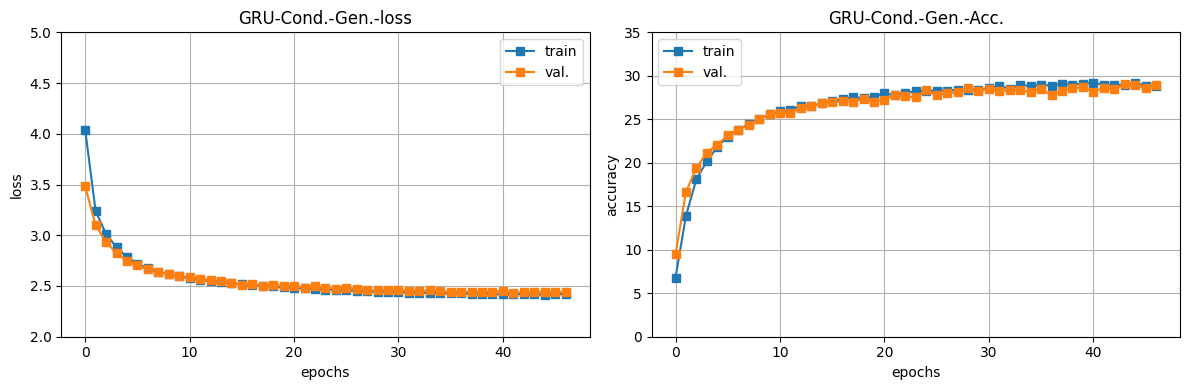

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot(
    targets=(train_state["train_loss"], train_state["val_loss"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "loss",
    ylim =[2, 5],
    grid = True,
    title = "GRU-Cond.-Gen.-loss",
    legend=True,
    markers="s"
    )
plt.subplot(122)
plot(
    targets=(train_state["train_acc"], train_state["val_acc"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "accuracy",
    grid = True,
    ylim=[0,35],
    title = "GRU-Cond.-Gen.-Acc.",
    legend=True,
    markers="s"
    )
plt.tight_layout()
plt.show()

In [26]:
import pickle

with open(base_path + "Conditioned_Train_State.pickle", "wb") as f:
  pickle.dump(train_state, f)